In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import random
import pulp

# Simulation of Energy Storage Systems - Mixed Integer Linear Program

Building off work done in "practice_interview_questions".

Create a Python simulation for a battery energy storage system. The simulation should take as input the storage capacity (in MWh), charge/discharge rates (in MW), energy costs, and simulate how the storage system responds to a given load profile over 24 hours. Your script should also calculate the efficiency losses due to charging and discharging and demonstrate how energy storage can aid in load balancing.

Skills Tested: Understanding of energy storage systems, simulation skills, basic physics and engineering principles related to energy efficiency.

## Set Up Sample Data & Input Parameters

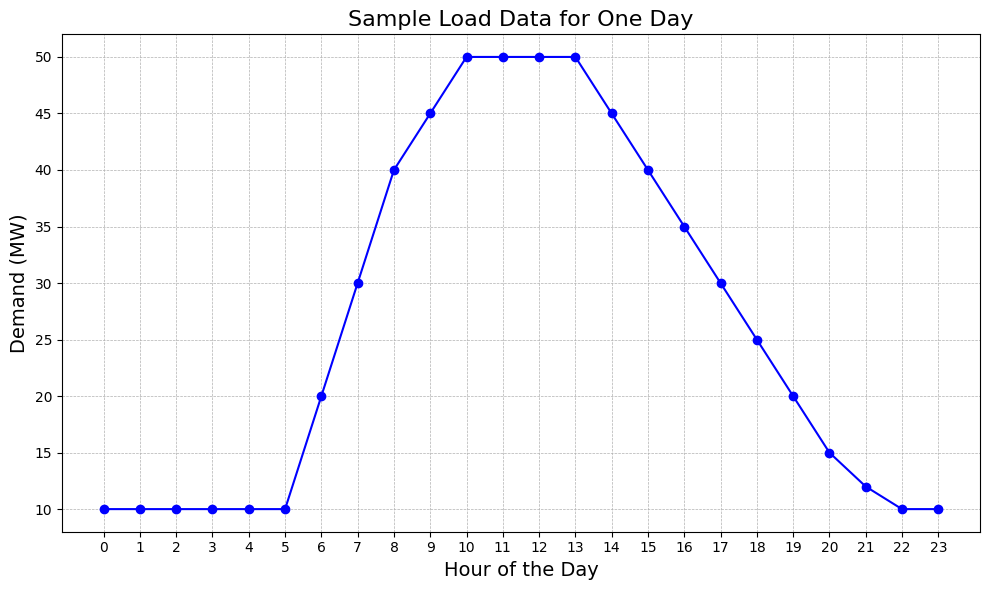

In [2]:
# Sample hourly load profile data in MW
load_data = {
    'hour': range(24),
    'demand_mw': [
        10, 10, 10, 10, 10, 10,  # 00:00 - 05:00 Low demand
        20, 30, 40, 45, 50, 50,  # 06:00 - 11:00 Increasing demand
        50, 50, 45, 40, 35, 30,  # 12:00 - 17:00 High demand
        25, 20, 15, 12, 10, 10   # 18:00 - 23:00 Decreasing demand
    ]
}

# Create a DataFrame
load_profile_df = pd.DataFrame(load_data)

# Display the DataFrame
#load_profile_df['demand_mw'].plot(title="Sample Load Data for One Day (MW)")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(load_profile_df['hour'], load_profile_df['demand_mw'], marker='o', linestyle='-', color='blue')
plt.title("Sample Load Data for One Day", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Demand (MW)", fontsize=14)
plt.xticks(range(0, 24, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

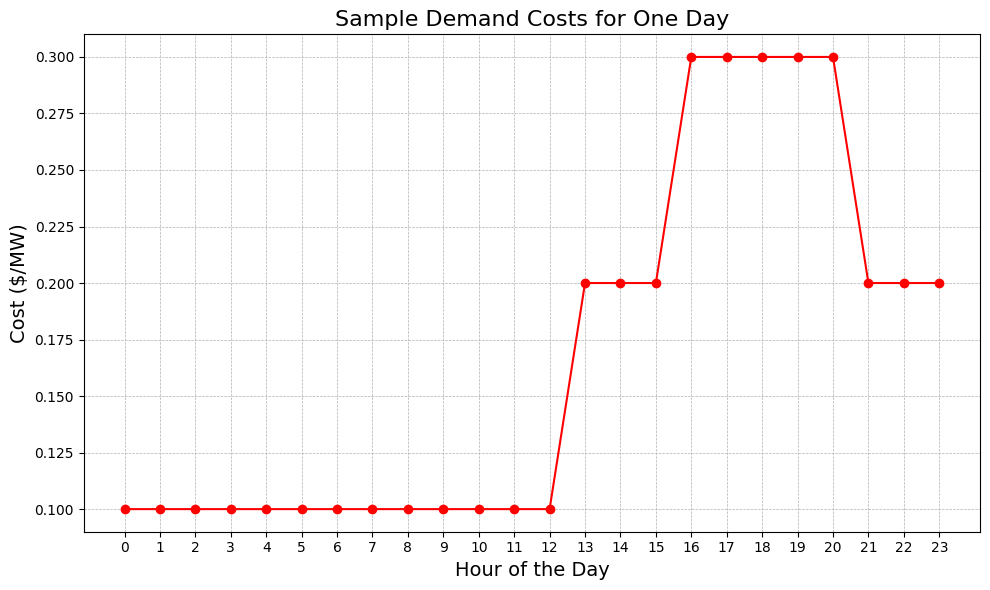

In [3]:
# Sample hourly energy cost data in $/MW
# Highest costs, the "peak period", is from 16:00-21:00 
# The partial peak period is 3 hours before and 3 hours after the peak period
cost_data = {
    'hour': range(24),
    'cost_mw': [
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 00:00 - 05:00 Low cost
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 06:00 - 11:00 Low cost
        0.1, 0.2, 0.2, 0.2, 0.3, 0.3,  # 12:00 - 17:00 Low-Med-High cost
        0.3, 0.3, 0.3, 0.2, 0.2, 0.2   # 18:00 - 23:00 High-Med-Low cost
    ]
}

# Create a DataFrame
cost_profile_df = pd.DataFrame(cost_data)

# Display the DataFrame
#cost_profile_df['cost_mw'].plot(title="Costs for One Day")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cost_profile_df['hour'], cost_profile_df['cost_mw'], marker='o', linestyle='-', color='red')
plt.title("Sample Demand Costs for One Day", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Cost ($/MW)", fontsize=14)
plt.xticks(range(0, 24, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
# Combine load and cost dataframes
load_cost = load_profile_df.copy()
load_cost["cost_mw"] = cost_profile_df['cost_mw']
load_cost.set_index("hour", inplace=True)

load_cost

,demand_mw,cost_mw
hour,,
0,10,0.1
1,10,0.1
2,10,0.1
3,10,0.1
4,10,0.1
5,10,0.1
6,20,0.1
7,30,0.1
8,40,0.1


In [5]:
# Default Parameters
ESS_CAPACITY = 30 # MWH
ESS_CHARGE_RATE = 15 # MW
ESS_DISCHARGE_RATE = 15 # MW
RTE = 0.88
SWITCH_COST = 0.05 # equivalent to half the off peak price

# demand_t is the column demand_mw from the load_cost dataframe
# price_t is the column cost_mw from the load_cost dataframe

## Set Up Class BatteryOptimizationModel
With inputs sample hourly load profile data frame in MW (load_data_df) and sample hourly cost data in $/MWh (cost_profile_df) and returns results_df. ESS parameters are optional inputs.

Decision Variables
- C_t is the amount of energy (MWh) charged in hour t
- D_t is the amount of energy (MWh) discharged in hour t
- SOC_t is the amount of energy (MWh) available in the battery in hour t
- Grid_t is the amount of energy (MWh) drawn from the grid in hour t

Parameters
- ESS_CAPACITY: the maximum battery capacity in MWh
- ESS_CHARGE_RATE: the maximum battery charge rate in MW
- ESS_DISCHARGE_RATE: the maximum battery discharge rate in MW
- RTE: the the round trip efficiency of the battery in percent (%)
- demand_t or demand_mw: the demand of the load at hour t (MWh)
- price_t or cost_mw: the cost of the energy at hour t ($/MWh)

Constraints
- 0 <= SOC_t <= ESS_CAPACITY for t from 0-24
- 0 <= C_t <= ESS_CHARGE_RATE
- 0 <= D_t <= ESS_DISCHARGE_RATE
- D_t <= SOC_t
- SOC_t = SOC_t-1 + C_t - D_t/RTE  (accounting for RTE losses) for t from 0-24
- D_t + grid_t >= demand_t
- SOC_0 = 0 initial boundary condition
- grid_t = max(demand_t - D_t, 0)
- D_t * C_t = 0 (note that i model this differently using binary decision variables, see below)

Objective
- Minimize the cost of energy for the building load across one day using a battery
min(sum((grid_t)*price_t) for t from 0-24)

In [16]:
class BatteryOptimizationModel:
    def __init__(self, ess_capacity=30, ess_charge_rate=15, ess_discharge_rate=15, rte=0.88, switch_cost = 0.05):
        """
        Initialize the battery optimization model with default ESS parameters.
        
        :param ess_capacity: Energy Storage System capacity in MWh
        :param ess_charge_rate: Maximum charge rate in MW
        :param ess_discharge_rate: Maximum discharge rate in MW
        :param rte: Round-Trip Efficiency of the storage system
        :param switch_cost: a small cost to disincentivize switching
        """
        self.ESS_CAPACITY = ess_capacity
        self.ESS_CHARGE_RATE = ess_charge_rate
        self.ESS_DISCHARGE_RATE = ess_discharge_rate
        self.RTE = rte
        self.RTE_INVERSE = 1/rte
        self.SWITCH_COST = switch_cost
        
    def run_optimization(self, load_profile_df, cost_profile_df):
        """
        Run the optimization given the load and cost profiles.

        :param load_profile_df: DataFrame with hourly load profile data in MW
        :param cost_profile_df: DataFrame with hourly cost data in $/MWh
        :return: DataFrame with the optimization results
        """
        
        print("Starting optimization process.")
        
        # Create load_cost dataframe
        load_cost = load_profile_df.copy()
        load_cost["cost_mw"] = cost_profile_df['cost_mw']
        load_cost.set_index("hour", inplace=True)
        
        # Create a PuLP Model
        model = pulp.LpProblem("BatteryOptimization", pulp.LpMinimize)
        
        # Create decision variables using _define_variables private function
        charge, discharge, soc, grid, is_charging, is_discharging, persistent_charge, persistent_discharge = self._define_variables(load_cost)
        
        # Add objective function using _add_objective_function private function
        self._add_objective_function(model, load_cost, grid, persistent_charge, persistent_discharge)
        
        # Add constraints using _add_constraints private function
        self._add_constraints(model, load_cost, charge, discharge, soc, grid, is_charging, is_discharging, persistent_charge, persistent_discharge)
        
        # Solve model
        model.solve()
        
        # Check optimization status
        if model.status == pulp.LpStatusOptimal:
            print("Congrats! Optimization completed successfully.")
            return self._extract_results(load_cost, charge, discharge, soc, grid)
        elif model.status == pulp.LpStatusInfeasible:
            print("Optimization problem is infeasible.")
        elif model.status == pulp.LpStatusUnbounded:
            print("Optimization problem is unbounded.")
        else:
            print(f"Optimization ended with status: {model.status}")

        return None  # or an appropriate default value
        
        # Return extracted results from private function _extract_results
        return self._extract_results(load_cost, charge, discharge, soc, grid)
    
    def _define_variables(self, load_cost):
        """
        Define the decision variables for the optimization model.

        :param load_cost: DataFrame with load and cost data
        :return: Tuple of dictionaries for charge, discharge, state of charge (soc), and grid usage variables
        """
        
        print("Defining decision variables.")
        
        # Decision Variables
        charge = pulp.LpVariable.dicts("Charge", load_cost.index, lowBound=0, cat='Continuous')
        discharge = pulp.LpVariable.dicts("Discharge", load_cost.index, lowBound=0, cat='Continuous')
        soc = pulp.LpVariable.dicts("SOC", load_cost.index, lowBound=0, cat='Continuous')
        grid = pulp.LpVariable.dicts("Grid", load_cost.index, lowBound=0, cat='Continuous')

        # Since charge[t] * discharge[t] == 0 is a non-linear problem we re-establish using binary variables
        is_charging = pulp.LpVariable.dicts("IsCharging", load_cost.index, cat='Binary')
        is_discharging = pulp.LpVariable.dicts("IsDischarging", load_cost.index, cat='Binary')

        # Create a persistent state decision variable for charging and discharging
        persistent_charge = pulp.LpVariable.dicts("PersistentCharge", load_cost.index, lowBound=0, cat='Continuous')
        persistent_discharge = pulp.LpVariable.dicts("PersistentDischarge", load_cost.index, lowBound=0, cat='Continuous')
        
        return charge, discharge, soc, grid, is_charging, is_discharging, persistent_charge, persistent_discharge
    
    def _add_objective_function(self, model, load_cost, grid, persistent_charge, persistent_discharge):
        """
        Add the objective function to the model.

        :param model: The PuLP model
        :param load_cost: DataFrame with load and cost data
        :param grid: Dictionary of grid usage variables
        :param persistent_charge: Dictionary for persistent charge state variables
        :param persistent_discharge: Dictionary for persistent discharge state variables
        """
        
        print("Adding objective function to the model.")
        
        model += pulp.lpSum([grid[t] * load_cost.cost_mw[t] for t in load_cost.index]) + self.SWITCH_COST * (pulp.lpSum([persistent_charge[t] for t in load_cost.index[1:]]) + pulp.lpSum([persistent_discharge[t] for t in load_cost.index[1:]]))
        
    def _add_constraints(self, model, load_cost, charge, discharge, soc, grid, is_charging, is_discharging, persistent_charge, persistent_discharge):
        """
        Add the constraints to the model.

        :param model: The PuLP model
        :param load_cost: DataFrame with load and cost data
        :param charge: Dictionary of charge variables
        :param discharge: Dictionary of discharge variables
        :param soc: Dictionary of state of charge variables
        :param grid: Dictionary of grid variables
        :param is_charging: Dictionary of binary is charging variables
        :param is_discharging: Dictionary of binary is discharging variables
        :param persistent_charge: Dictionary of persistent charge variables
        :param persistent_discharge: Dictionary of persistent discharge variables
        """
        
        print("Adding constraints to the model.")
        
        for t in load_cost.index:
            if t == 0:
                # Initial boundary condition
                model += soc[t] == 0
                model += persistent_charge[t] == 0
                model += persistent_discharge[t] == 0
            else:
                # SOC constraint
                model += 0 <= soc[t] <= self.ESS_CAPACITY
                # Maximum charge/discharge rate constraints
                model += charge[t] <= self.ESS_CHARGE_RATE * is_charging[t]
                model += discharge[t] <= self.ESS_DISCHARGE_RATE * is_discharging[t]
                # Discharge cannot be greater than SOC available
                model += discharge[t] <= soc[t]
                # Account for RTE when calculating SOC
                model += soc[t] == soc[t-1] + charge[t] - discharge[t] * self.RTE_INVERSE
                # Ensure building demand is met
                model += discharge[t] + grid[t] >= load_cost.demand_mw[t]
                # Define grid, ensure it cannot go negative 
                model += grid[t] == load_cost.demand_mw[t] - discharge[t] + charge[t]
                model += grid[t] >= 0
                # Ensure battery can't charge and discharge simultaneously
                model += is_charging[t] + is_discharging[t] <= 1
                # Charging persistence constraints
                model += persistent_charge[t] >= charge[t] - charge[t-1]
                model += persistent_charge[t] >= charge[t-1] - charge[t]
                # Discharging persistence constraints
                model += persistent_discharge[t] >= discharge[t] - discharge[t-1]
                model += persistent_discharge[t] >= discharge[t-1] - discharge[t]

    def _extract_results(self, load_cost, charge, discharge, soc, grid):
        """
        Extract results from the optimization model.

        :param load_cost: DataFrame with load and cost data
        :param charge: Dictionary of charge variables
        :param discharge: Dictionary of discharge variables
        :param soc: Dictionary of state of charge variables
        :param grid: Dictionary of grid usage variables
        :return: DataFrame with the results
        """
        
        print("Extracting results from the model.")
        
        results = {
            'Hour': load_cost.index,
            'Charge': [charge[t].varValue for t in load_cost.index],
            'Discharge': [discharge[t].varValue for t in load_cost.index],
            'SOC': [soc[t].varValue for t in load_cost.index],
            'Grid': [grid[t].varValue for t in load_cost.index],
            'Demand': load_cost['demand_mw'],
            'Cost': load_cost['cost_mw']
        }

        results_df = pd.DataFrame(results).set_index('Hour')
        return results_df

In [17]:
model = BatteryOptimizationModel()
results_df = model.run_optimization(load_profile_df, cost_profile_df)

Starting optimization process.
Defining decision variables.
Adding objective function to the model.
Adding constraints to the model.
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/zoemcbride/repos/energy-data-lab/energy-venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/c0b58a933fd44346b490cf6d3c26f37d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/c0b58a933fd44346b490cf6d3c26f37d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 307 COLUMNS
At line 1186 RHS
At line 1489 BOUNDS
At line 1536 ENDATA
Problem MODEL has 302 rows, 190 columns and 716 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 100.402 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed mo

In [18]:
def plot_optimization_results(results_df):
    """
    :param results_df: dataframe containing the hour as index, and columns 'Charge', 'Discharge', 'SOC', 'Cost', 'Demand', 'Grid'
    """

    # Plotting
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(results_df.index, results_df['SOC'], label='State of Charge', color='orange')
    plt.ylabel('MWh')
    plt.title('State of Charge of the Battery')

    plt.subplot(4, 1, 2)
    plt.plot(results_df.index, results_df['Charge'], label='Charge', color='green')
    plt.plot(results_df.index, results_df['Discharge'], label='Discharge', color='red')
    plt.ylabel('MW')
    plt.legend()
    plt.title('Charging and Discharging')

    plt.subplot(4, 1, 3)
    plt.plot(results_df.index, results_df['Cost'], label='Energy Costs', color='purple')
    plt.xlabel('Hour')
    plt.ylabel('$/MWh')
    plt.title('Energy Costs')

    plt.subplot(4, 1, 4)
    plt.plot(results_df.index, results_df['Demand'], label='Building Load', color='blue')
    plt.plot(results_df.index, results_df['Grid'], label='Grid', color='purple')
    plt.xlabel('Hour')
    plt.ylabel('MW')
    plt.title('Demand and Grid Usage')

    plt.legend()
    plt.tight_layout()
    plt.show()


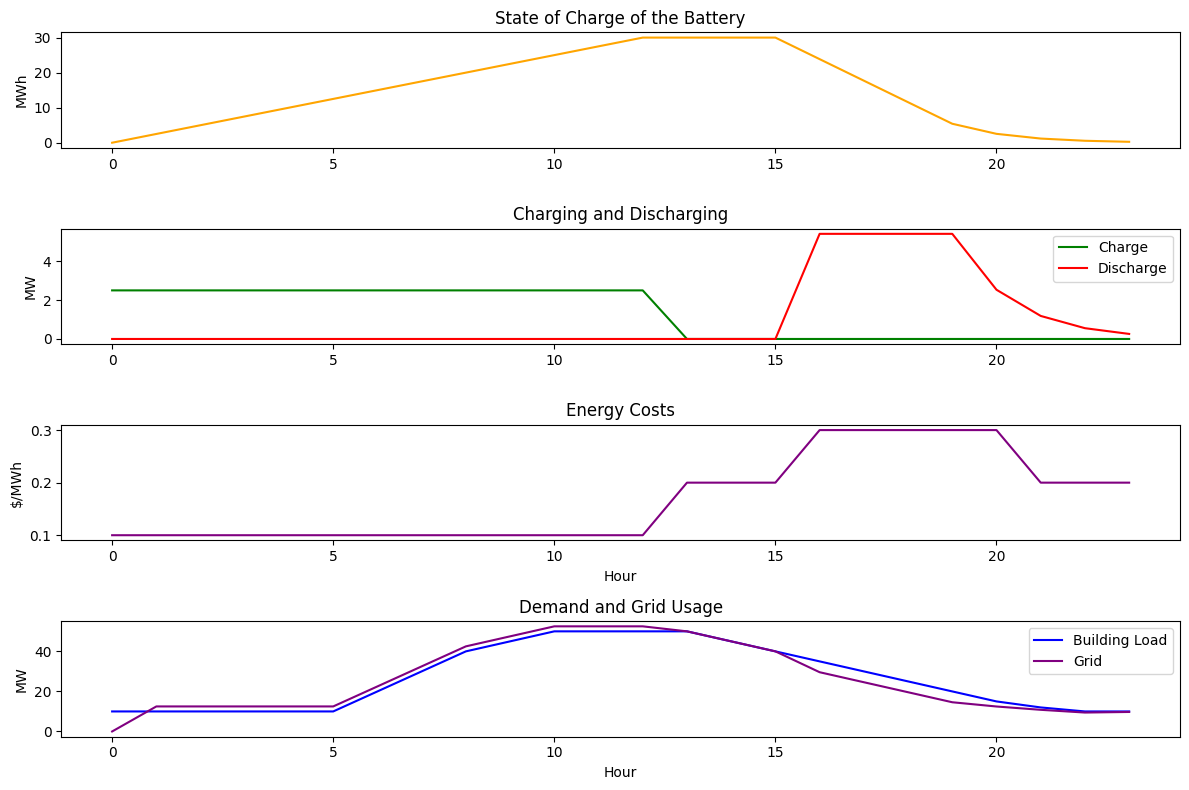

In [19]:
plot_optimization_results(results_df)

In [20]:
total_grid_cost = sum(results_df['Grid']*results_df['Cost'])
total_baseline_cost = sum(results_df['Demand']*results_df['Cost'])
delta = total_baseline_cost - total_grid_cost

print(f"The baseline cost was ${round(total_baseline_cost,2)} and the total post-ess cost was ${round(total_grid_cost,2)}.")
print(f"Thus in 24 hours the battery saved the building ${round(delta, 2)}, or {round(delta/total_baseline_cost*100,2)}% of it's energy costs.")



The baseline cost was $105.4 and the total post-ess cost was $99.75.
Thus in 24 hours the battery saved the building $5.65, or 5.36% of it's energy costs.


The above graphs show the battery charging smoothly during the off-peak period, holding during the first partial-peak period, and then discharging smoothly through the on-peak and following partial-peak period. The battery discharges more aggressively during the on-peak period, as expected, but still continues to discharge what energy it has left for the final partial-peak period.

This behavior seems both realistic and impressive! It is cool to see that our simulated ESS can save the building over 5% of its energy bill in one day. Obviously, this is a small example, but I would be curious to see how it would perform over longer periods of time.